## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from IPython.display import clear_output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Model

In [2]:
# model = models.resnet50()
# model.fc = nn.Linear(2048,100)
from mnist_model import model

# Load weigths from the model trained on upstream task
# model_file = './archive/model.pth'
# state_dict = torch.load(model_file)
# model.load_state_dict(state_dict)

# Decide whether to freeze or finetune the model
# for param in model.parameters():
#     param.requires_grad = False

# linear_reg = nn.Linear(100,10)
# model = nn.Sequential(model, linear_reg)

#print(model)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

## Load Synthetic MNIST

In [3]:
transform = transforms.Compose([transforms.Resize(245),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_set = datasets.ImageFolder('/misc/vlgscratch4/LakeGroup/vaibhav/data/synthetic_digits/imgs_train', transform=transform)
val_set = datasets.ImageFolder('/misc/vlgscratch4/LakeGroup/vaibhav/data/synthetic_digits/imgs_valid', transform=transform)
print("Length of training set is %d." %len(train_set))
print("Length of training set is %d." %len(val_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

Length of training set is 10000.
Length of training set is 2000.


## Train the Network

In [4]:
def train(epoch):
    model.train()
    running_loss = 0
    lr = optimizer.param_groups[0]['lr']
    for images, labels  in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %3d | Running Loss: %f | LR : %.9f" 
          % (epoch, running_loss, lr))
    return running_loss


def validation():
    model.eval()
    scheduler.step()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).to(device).sum()
    return correct.item()

Epoch:   0 | Running Loss: 192.640598 | LR : 0.001000000
Correct Samples = 1575 || Accuracy = 0.79
Epoch:   1 | Running Loss: 86.120432 | LR : 0.001000000
Epoch:   2 | Running Loss: 52.871110 | LR : 0.001000000
Epoch:   3 | Running Loss: 36.017855 | LR : 0.001000000
Epoch:   4 | Running Loss: 26.217930 | LR : 0.001000000
Epoch:   5 | Running Loss: 21.278972 | LR : 0.001000000
Correct Samples = 1794 || Accuracy = 0.90
Epoch:   6 | Running Loss: 16.902246 | LR : 0.001000000
Epoch:   7 | Running Loss: 14.519678 | LR : 0.001000000
Epoch:   8 | Running Loss: 14.389731 | LR : 0.001000000
Epoch:   9 | Running Loss: 10.995138 | LR : 0.001000000
Epoch:  10 | Running Loss: 11.825016 | LR : 0.001000000
Correct Samples = 1797 || Accuracy = 0.90
Epoch:  11 | Running Loss: 11.566380 | LR : 0.001000000
Epoch:  12 | Running Loss: 11.557535 | LR : 0.001000000
Epoch:  13 | Running Loss: 8.989956 | LR : 0.001000000
Epoch:  14 | Running Loss: 8.380363 | LR : 0.001000000
Epoch:  15 | Running Loss: 7.567797

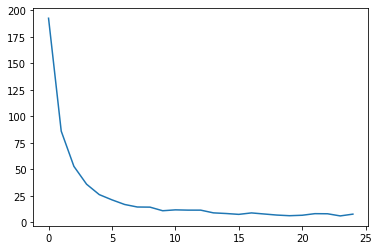

In [5]:
epochs = 25
#max_accuracy = 0
train_losses = []
for epoch in range(epochs):
    train_losses.append(train(epoch))
    if epoch%5 == 0:
        accuracy = validation()
        print("Correct Samples = %d || Accuracy = %.2f" %(accuracy, accuracy/len(val_set)))

plt.plot(train_losses)